<center> <b> <font size="+2"> DIGIT CLASSIFICATION </font> </b> </center> 

Michał Thor, Bartłomiej Kowalczuk  

In this project we wanted to created digit classifier that would be trained on data published on https://github.com/kensanata/numbers.  
Using that data we created a dataset that consits of 10.000 images, all rescaled to 28x28 resolution, all in grayscale.

So basically, we transformed each of the images into 1x784 vector that has information about each pixel in the image. Then we used it as "one row" input into our models. 

We used Support Vector Machines algorithm, which after tuning, scored <b>92%</b> accuracy on the test set.  
Then we used Convolutional Neural Network, which we tuned to gave us almost <b>99%</b> accuracy.

In [1]:
# testing if there are available gpu's to train the network on
from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


## Import libraries

In [19]:
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_recall_fscore_support
from subprocess import check_output
from PIL import Image

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.optimizers import Adam
from keras.models import load_model

### Displaying sample image

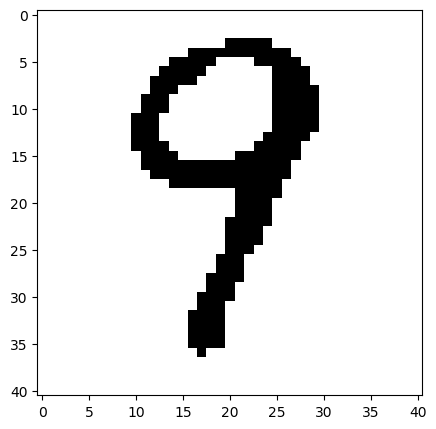

In [96]:
plt.figure(figsize=(10,5))
pic = Image.open(f'data/9/number-0000000.png').convert('RGB')
plt.imshow(pic)

## Data preparation

(don't run the code, dataset is already prepared)

In [87]:
def data_prepare(digit = 0):
    image_list = []
    for file in glob.glob(f"data/{digit}/*.PNG"):
        pic = Image.open(file).convert('L')
        img = pic.resize((28,28), Image.ANTIALIAS)
        pix = np.array(img)
        flat_arr = pix.ravel()
        image_list.append(flat_arr)
    if len(image_list) < 1000:
        print("Something is wrong with the image list")
    # adding label to matrix row
    image_list_y = [np.insert(item,0,digit,axis=0) for item in image_list]
    images_matrix = np.array(image_list_y)
    if images_matrix.shape != (1000, 785):
        print("Something is wrong with matrix shape")
    else:
        print(digit, images_matrix.shape)
    
    return images_matrix

In [ ]:
# using data_prepare function for all digits (subfolders)
for digit in range(0,10):
    if digit == 0:
        im = data_prepare(digit)
    else:
        im_temp = data_prepare(digit)
        im = np.concatenate((im, im_temp), axis=0)

In [ ]:
# saving to csv
df_array = pd.DataFrame(im)
df_array.to_csv("df.csv")

## Load the dataset

In [2]:
#loading the dataset.......(Train)
df = pd.read_csv("df.csv")
print(df.shape)
df = df.drop(["Unnamed: 0"], axis = 1)
df.columns.values[0] = 'label' # renaming first column to label (y)
df.head(3)
print("Any missing sample in the dataset:", df.isnull().values.any())

(10000, 786)
Any missing sample in the dataset: False


### Splitting into train/test

In [3]:
train, test = train_test_split(df, test_size=0.2)

In [4]:
# casting values as numeric (making sure they are int/float)
x_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
x_test = test.iloc[:,1:].values.astype('float32')
y_test = test.iloc[:,0].values.astype('int32')
# num_classes = 10
# y_test = keras.utils.to_categorical(y_test, num_classes)

### Preview the images

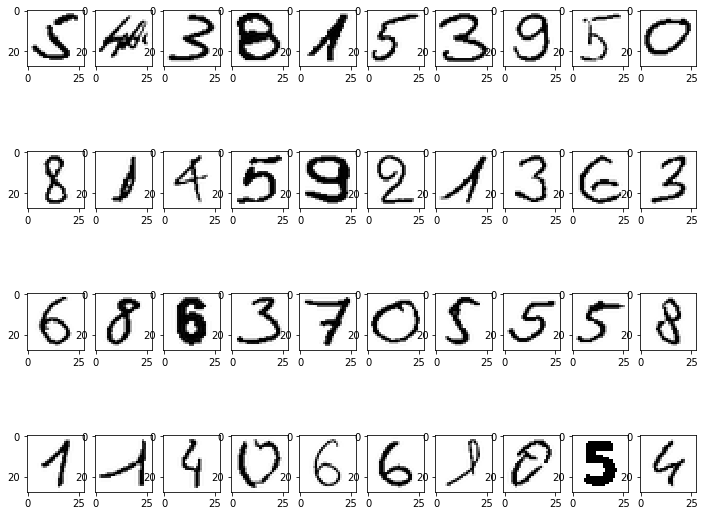

In [6]:
plt.figure(figsize=(12,10))
x, y = 10, 4
for i in range(40):  
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i].reshape((28,28)),interpolation='nearest', cmap="gray")
plt.show()

### Normalise data

In [5]:
# all values are normalized to values between 0 an 1
x_train = x_train/255.0
x_test = x_test/255.0

In [6]:
# checking if all dimensions are correct
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (8000, 784)
8000 train samples
2000 test samples


### Reshaping (for SVM)

In [7]:
X_train = x_train.reshape(x_train.shape[0], 784)
X_test = x_test.reshape(x_test.shape[0], 784)

***

> # SVM 

In [8]:
# SVM cross validation
names_of_predictors = list(df.iloc[:,1:].columns.values)

# Creating the parameter grid
params_grid = [{'kernel': ['rbf'], # non linear
                'gamma': [1e-3, 1e-4], # the higher the gamma value the more it tries to exactly fit the training dataset
                'C': [1, 5, 8, 10, 100, 1000]}, # too large C parameter may lead to overfitting / controls the trade off between smooth decision boundary and classifying the training points correctly
               {'kernel': ['linear'], # linear
                'C': [1, 5, 8, 10, 100, 1000]},
              {'kernel': ['poly'],
               'degree': [2,3], # degree of the polynomial used to find the hyperplane to split the data
                'C': [1, 5, 8, 10, 100, 1000]}]

In [9]:
# Scaling sets (first we fit the scaler to training data and then use it to transform test data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<center> <font color=red size="+1"> <b>  WARNING GRIDSEARCH MAY TAKE MORE THAN 3 HOURS </b> </font> <center>

In [10]:
# Performing Cross Validation to tune parameters for best SVM fit 
svm_model = GridSearchCV(SVC(), params_grid, cv=5)
svm_model.fit(X_train, y_train)

C:\Users\b.kowalczuk\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\b.kowalczuk\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\b.kowalczuk\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 5, 8, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 5, 8, 10, 100, 1000]}, {'kernel': ['poly'], 'degree': [2, 3], 'C': [1, 5, 8, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
print('Best score for training data:', svm_model.best_score_) # 0.899875 

# View the best parameters for the model found using grid search
print('Best C:',svm_model.best_estimator_.C) # 8 
print('Best Kernel:',svm_model.best_estimator_.kernel) # poly
print('Best Gamma:',svm_model.best_estimator_.gamma) # auto_deprecated
print('Best Degree:',svm_model.best_estimator_.degree) # 3

Best score for training data: 0.91925
Best C: 8
Best Kernel: poly
Best Gamma: auto_deprecated
Best Degree: 3


In [15]:
svm_model = SVC(C = 8,
                degree = 3, # degree of the polynomial used to find the hyperplane to split the data (used only in "poly")
                gamma = 'auto_deprecated', # the higher the gamma value the more it tries to exactly fit the training dataset
                kernel ='poly',
                shrinking = True, # reduces number of variables in the training process to speed up computation
                verbose = False).fit(X_train, y_train) 

svm_predictions = svm_model.predict(X_test) 

C:\Users\b.kowalczuk\AppData\Local\Continuum\anaconda3\envs\py36\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


### Accuracy and confusion matrix

In [16]:
# model accuracy for X_test   
accuracy_svm = svm_model.score(X_test, y_test) 
  
# creating a confusion matrix 
cm_svm = confusion_matrix(y_test, svm_predictions) 

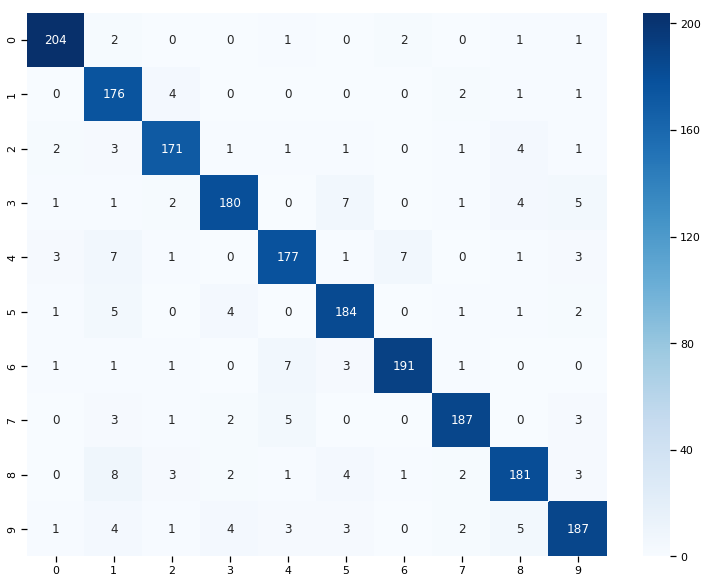

In [18]:
plt.figure(figsize=(13,10))
sns.set_context("notebook")
sns.heatmap(cm_svm, annot = True, fmt="d", cmap="Blues")
plt.show()

### Classification report SVM


Training set score for SVM: 0.956250
Testing  set score for SVM: 0.919000


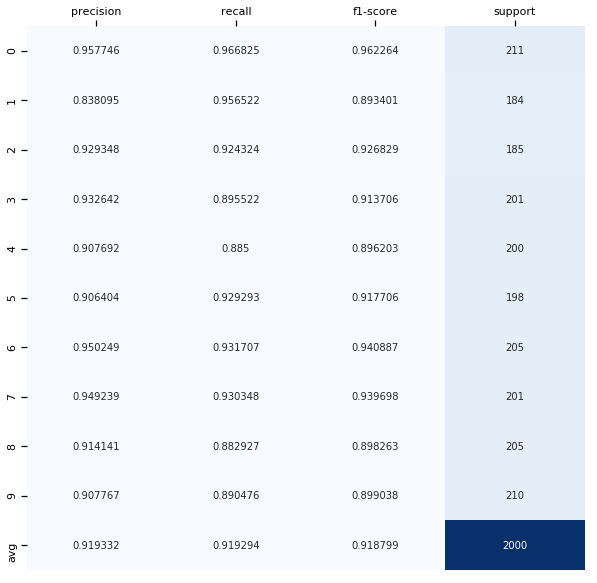

In [20]:
def plot_classification_report(y_tru, y_prd, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = list(np.unique(y_tru))
    yticks += ['avg']

    rep = np.array(precision_recall_fscore_support(y_tru, y_prd)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    ax = sns.heatmap(rep,
                    annot=True, 
                    cbar=False, 
                    xticklabels=xticks, 
                    yticklabels=yticks,
                    ax=ax,
                    cmap="Blues",
                    fmt='g')
    ax.xaxis.set_ticks_position('top')
    
print()
plot_classification_report(y_test, svm_predictions)

print("Training set score for SVM: %f" % svm_model.score(X_train , y_train))
print("Testing  set score for SVM: %f" % svm_model.score(X_test  , y_test ))

***

> # CNN

In [ ]:
# reshaping for cnn (keras requires input to be three-dimensional - in case of images with colours)
X_train = x_train.reshape(x_train.shape[0], 28, 28,1)
X_test = x_test.reshape(x_test.shape[0], 28, 28,1)

In [10]:
# base hyperparameters
batch_size = 100 # number of observations that goes through the network in each iteration
num_classes = 10 # number of distinct classes of y-variable - 10 digits
epochs = 20 # number of "iterations"
input_shape = (28, 28, 1)

In [11]:
# convert class vectors to binary class matrices (one hot encoding)
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

# split training into train and validation (for the network to learn on error in real time - avoid overfitting)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=42)

### In our network we find out that it works the best on such hyperparameters set:
- 5 hidden layers
- init weights from he_normal distribution
- reLU activation function in each layer, apart from the output layer
- first 5 layers are two-dimensional convolution layer
- some dropouts to reduce the power of layers ("turn off" part of neurons)
- Adam optimizer with learning rate equal to 0.01 (how much are the weights updated each epoch) and decay equal to 0.01 (reducing the learning rate during training process)
- we also use some additional learning rate reduction function - ReduceLROnPlateau
- our loss function is categorical crossentropy
- dense layer with softmax activation function to transform the output into vector of probabilities

However, it is possible that this set of parameters is not the best but we did not have proper machines to run proper grid search on this network.

In [13]:
# model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape)) # input layer
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
# output layer
model.add(Dense(num_classes, activation='softmax'))


# additional parameters and functions
opt = Adam(lr=0.01, decay = 0.01) 

# compile the model
model.compile(loss=keras.losses.categorical_crossentropy,
#               optimizer=keras.optimizers.RMSprop(),
              optimizer = opt,
              metrics=['accuracy'])


learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', # we check if this value is improving
                                            patience=3, # number of epochs with no improvement after which learning rate will be reduced
                                            verbose=1, 
                                            factor=0.5, # reducing learning rate by lr * factor
                                            min_lr=0.0001)

# es = EarlyStopping(monitor='loss', mode='min', verbose=1)

history = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

In [26]:
# model.summary()

<center> <font color=red size="+1"> <b> WARNING THE TRAINING PROCESS IN THE NEXT CELL IS FAST BUT IT TAKES A LOT OF COMPUTING POWER
    <br /> (AND THAT CAN DAMAGE YOUR COMPUTER) </b> </font> </center>

In [14]:
history.fit(X_train)
h = model.fit_generator(history.flow(X_train,Y_train,
                                     batch_size=batch_size),
                                     epochs = epochs,
                                     validation_data = (X_val,Y_val),
                                     verbose = 1,
                                     steps_per_epoch=X_train.shape[0] // batch_size,
                                     callbacks=[learning_rate_reduction],)
#                                      callbacks = [es])

Instructions for updating:
Use tf.cast instead.
Epoch 1/20
72/72 [==============================] - 10s 144ms/step - loss: 1.5654 - acc: 0.4883 - val_loss: 2.9223 - val_acc: 0.2313
Epoch 2/20
72/72 [==============================] - 5s 75ms/step - loss: 0.8413 - acc: 0.7375 - val_loss: 6.2812 - val_acc: 0.0963
Epoch 3/20
72/72 [==============================] - 5s 76ms/step - loss: 0.4838 - acc: 0.8567 - val_loss: 5.3732 - val_acc: 0.1087
Epoch 4/20
72/72 [==============================] - 5s 74ms/step - loss: 0.3971 - acc: 0.8811 - val_loss: 0.9391 - val_acc: 0.6637
Epoch 5/20
72/72 [==============================] - 5s 75ms/step - loss: 0.3355 - acc: 0.8967 - val_loss: 1.4771 - val_acc: 0.4638
Epoch 6/20
72/72 [==============================] - 5s 75ms/step - loss: 0.2809 - acc: 0.9203 - val_loss: 0.7270 - val_acc: 0.7200
Epoch 7/20
72/72 [==============================] - 5s 76ms/step - loss: 0.2343 - acc: 0.9354 - val_loss: 0.4779 - val_acc: 0.8412
Epoch 8/20
72/72 [===============

### CPU and GPU usage during training

CPU at peaks reached 92 deegrees, and GPU around 80 degrees.

![title](cpu_temp2.JPG)

![title](gpu_usage.JPG)

### Save model file

In [64]:
model.save('model_digits_2.h5')

### Load model file

In [1]:
# model = load_model('model_digits.h5')

### Loss (cost) and accuracy

In [18]:
# loss and accuracy on validation set (from training set)
final_loss, final_acc = model.evaluate(X_val, Y_val, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.088983, final accuracy: 0.977500


In [19]:
# print(h.history.keys())
accuracy = h.history['acc']
val_accuracy = h.history['val_acc']
loss = h.history['loss']
val_loss = h.history['val_loss']
epochs = range(len(accuracy))

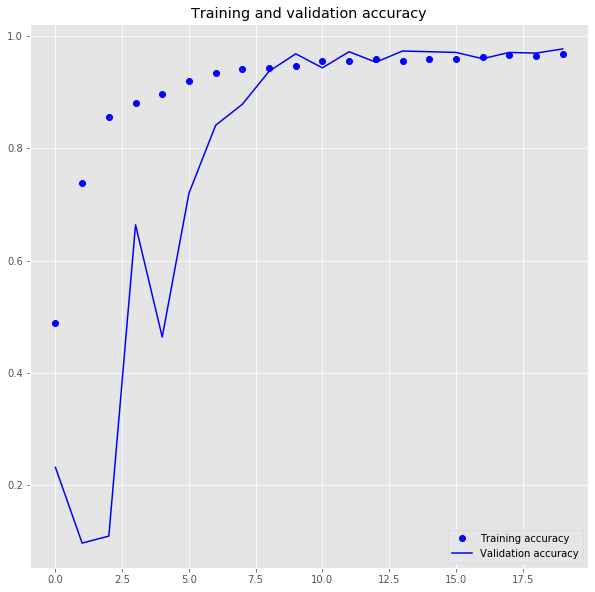

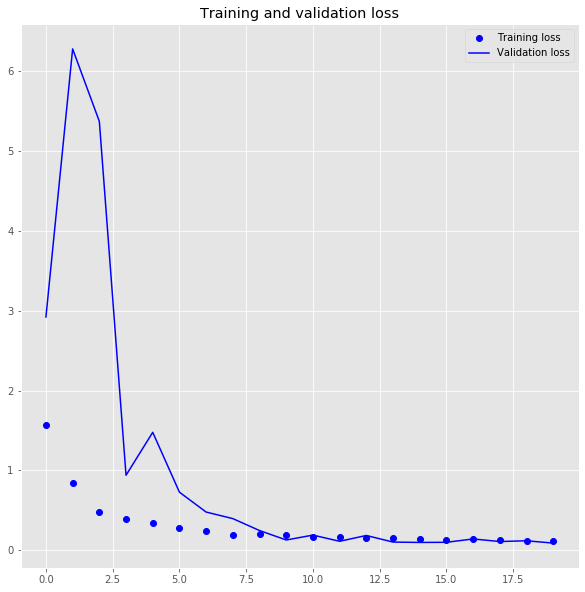

In [20]:
# accuracy
plt.figure(figsize=(10,10))
plt.style.use('ggplot')
# plt.style.use(['dark_background'])
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc='lower right')
plt.show()

# loss
plt.figure(figsize=(10,10))
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Confusion matrix

In [32]:
#Note, this code is taken straight from the SKLEARN website, an nice way of viewing confusion matrix.
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.style.use('default')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Confusion matrix for validation set (from training set)

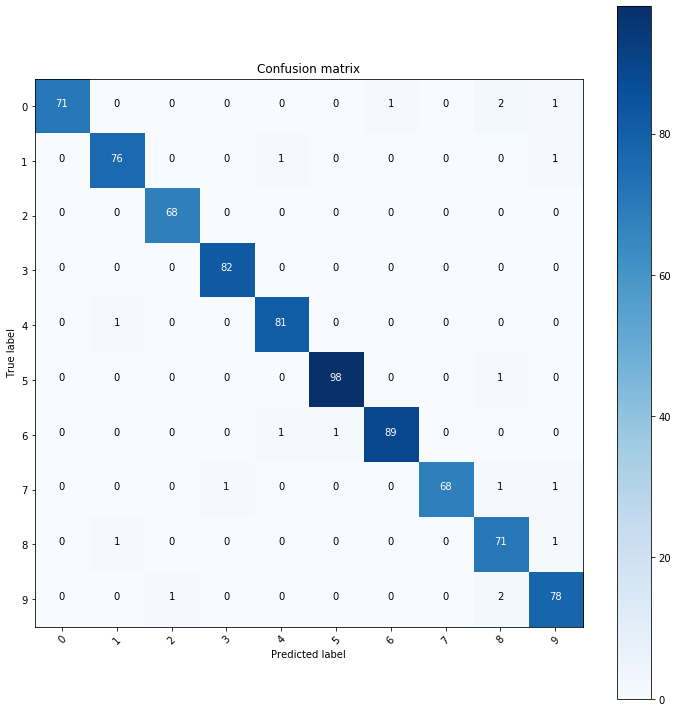

In [85]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

#### Confusion matrix for the test set

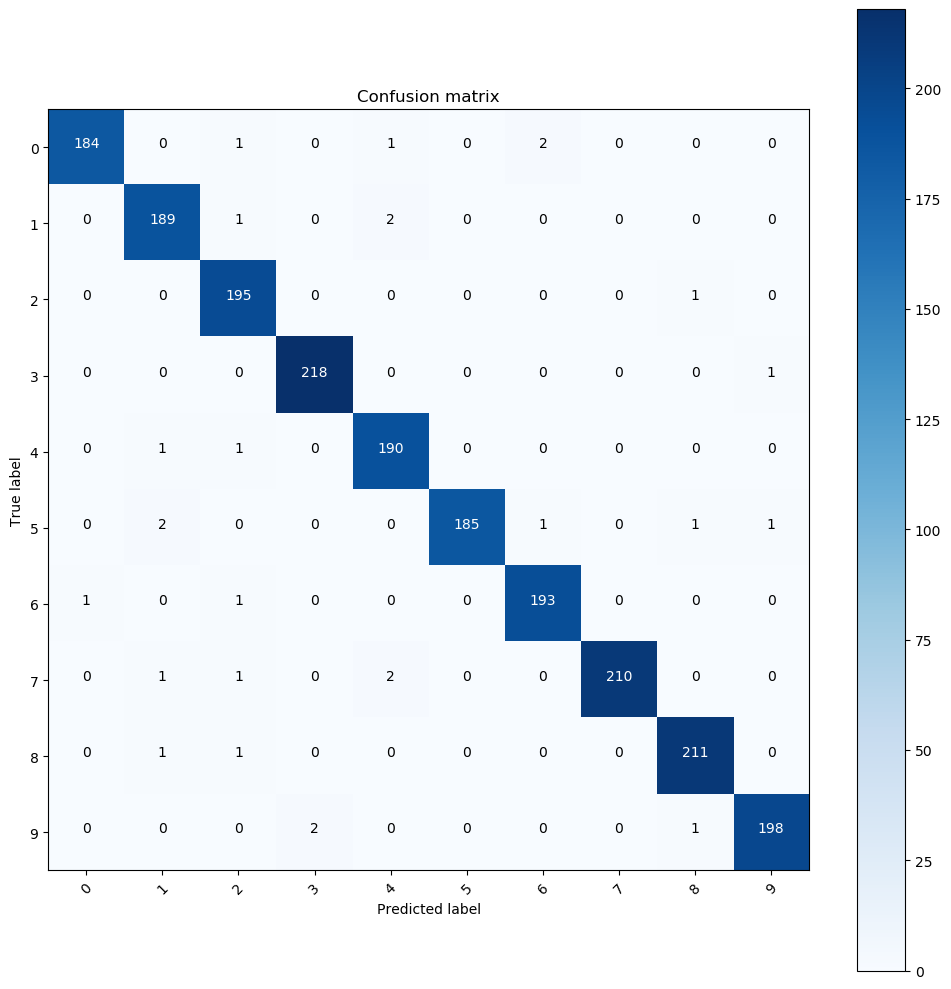

In [35]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test, axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(10))

### Classification report

In [48]:
y_test = test.iloc[:,0].values.astype('int32')
y_test = keras.utils.to_categorical(y_test, num_classes)

final_loss, final_acc = model.evaluate(X_test, y_test, verbose=0)
print("Final loss: {0:.6f}, final accuracy: {1:.6f}".format(final_loss, final_acc))

Final loss: 0.053931, final accuracy: 0.986500


In [41]:
#get the predictions for the test data
predicted_classes = model.predict_classes(X_test)

y_test = test.iloc[:,0].values.astype('int32')
#get the indices to be plotted
correct = np.nonzero(predicted_classes==y_test)[0]
incorrect = np.nonzero(predicted_classes!=y_test)[0]

In [42]:
from sklearn.metrics import classification_report
target_names = ["Class {}".format(i) for i in range(num_classes)]
print(classification_report(y_test, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      0.98      0.99       188
     Class 1       0.97      0.98      0.98       192
     Class 2       0.97      0.99      0.98       196
     Class 3       0.99      1.00      0.99       219
     Class 4       0.97      0.99      0.98       192
     Class 5       1.00      0.97      0.99       190
     Class 6       0.98      0.99      0.99       195
     Class 7       1.00      0.98      0.99       214
     Class 8       0.99      0.99      0.99       213
     Class 9       0.99      0.99      0.99       201

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

